In [ ]:
#! pip install sklearn

In [ ]:
#conda install -c conda-forge imbalanced-learn

In [ ]:
#! pip install mlxtend

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")

from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported f

In [ ]:
dataFrame_training = pd.read_csv('training_variants/training_variants')

print('Number of data points :',dataFrame_training.shape[0])
print('Number of Features(columns):',dataFrame_training.shape[1])
print('Column Names:',dataFrame_training.columns.values)
print('*'*50)
dataFrame_training.head()

Number of data points : 3321
Number of Features(columns): 4
Column Names: ['ID' 'Gene' 'Variation' 'Class']
**************************************************


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [ ]:
dataFrame_text = pd.read_csv("training_text/training_text",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)

In [ ]:
print('Number of data points :',dataFrame_text.shape[0])
print('Number of Features(dataFrame_text):',dataFrame_text.shape[1])
print('Column Names:',dataFrame_text.columns.values)
print('*'*50)
dataFrame_text.head()

Number of data points : 3321
Number of Features(dataFrame_text): 2
Column Names: ['ID' 'TEXT']
**************************************************


,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


# Text Pre-Processing

We are doing below steps:
    1. Removing Special characters
    2. Removing multiple spaces
    3. Converting all the words to lower case
    4. Then checking whtger the data is stop word or not, if not then I am keeping it or else dropping it

In [ ]:
#Load The Stop Words from the NTLK libraries which retrives a "Set" of stop words in english

stop_words = set(stopwords.words('english'))

def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        # replace every special char with space
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', total_text)
        # replace multiple spaces with single space
        total_text = re.sub('\s+',' ', total_text)
        # converting all the chars into lower-case.
        total_text = total_text.lower()
        
        for word in total_text.split():
        # if the word is a not a stop word then retain that word from the data
            if not word in stop_words:
                string += word + " "
        
        dataFrame_text[column][index] = string

In [ ]:
start_time = time.clock()

for index,row in dataFrame_text.iterrows():
    if type(row['TEXT']) is str:
        nlp_preprocessing(row['TEXT'],index,'TEXT')
    else:
        print("no text description for id:",index)
print('Time taken to process all the text',time.clock() - start_time, "seconds")

no text description for id: 1109
no text description for id: 1277
no text description for id: 1407
no text description for id: 1639
no text description for id: 2755
Time taken to process all the text 412.4417293 seconds


In [ ]:
#doing a left join on ID
result = pd.merge(dataFrame_training, dataFrame_text,on='ID', how='left')
result.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [ ]:
result[result.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


In [ ]:
result.loc[result['TEXT'].isnull(),'TEXT'] = result['Gene'] +' '+result['Variation']

In [ ]:
result[result['ID']==2755]

,ID,Gene,Variation,Class,TEXT
2755,2755,BRAF,G596C,7,BRAF G596C


# Train, validation and Test splitting

We dont have any temproal data, so that we can split it randomly.

In [ ]:
y_true = result['Class'].values
result.Gene      = result.Gene.str.replace('\s+', '_')
result.Variation = result.Variation.str.replace('\s+', '_')

#### split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]

#### split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]

In [ ]:
X_train,test_df,y_train,y_test = train_test_split(result,y_true,stratify = y_true,test_size =0.1)
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.1)

In [ ]:
print('Number of rows in train data ~70%:', train_df.shape[0])
print('Number of rows in test data ~10%:', test_df.shape[0])
print('Number of rows in cross validation data ~10%:', cv_df.shape[0])

Number of rows in train data ~70%: 2689
Number of rows in test data ~10%: 333
Number of rows in cross validation data ~10%: 299


### Since we have categorical values, we need to check the distribution of the class variable in all the train validation and test datset
#### It should be almost identical for the model to perform better
### Plotting the bar chart in ascending way so that it will be easy to check the target variable distributions

In [ ]:
def check_distribution(distributiondf):
    distributiondf.plot(kind='bar')
    plt.xlabel('Class')
    plt.ylabel('Rows per Class')
    plt.title('Distribution of Class variable(yi)')
    plt.grid()
    plt.show()
    #Perform an indirect sort along the given axis using the algorithm specified by the kind keyword. 
    #It returns an array of indices of the same shape as a that index data along the given axis in sorted order
    sorted_yi = np.argsort(-distributiondf.values)
    for i in sorted_yi:
        print('Number of rows belonging to class', i+1, ':',distributiondf.values[i], '(', np.round((distributiondf.values[i]/train_df.shape[0]*100), 3), '%)')
    print('-'*70)

In [ ]:
train_class_distribution = train_df['Class'].value_counts().sort_values()
test_class_distribution = test_df['Class'].value_counts().sort_values()
cv_class_distribution = cv_df['Class'].value_counts().sort_values()

## The Classes are Imbalance
## we are dealing with a multi class classification problem which is imbalance in nature
## Traing Data and Test dat Has similar distribution 

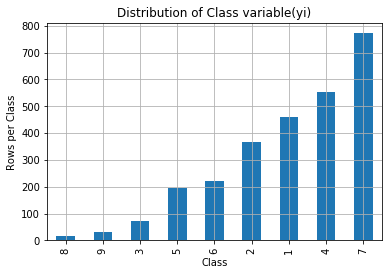

Number of rows belonging to class 9 : 772 ( 28.71 %)
Number of rows belonging to class 8 : 555 ( 20.64 %)
Number of rows belonging to class 7 : 460 ( 17.107 %)
Number of rows belonging to class 6 : 366 ( 13.611 %)
Number of rows belonging to class 5 : 222 ( 8.256 %)
Number of rows belonging to class 4 : 196 ( 7.289 %)
Number of rows belonging to class 3 : 72 ( 2.678 %)
Number of rows belonging to class 2 : 30 ( 1.116 %)
Number of rows belonging to class 1 : 16 ( 0.595 %)
----------------------------------------------------------------------


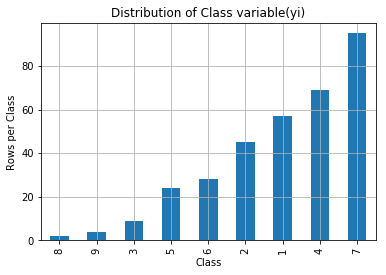

Number of rows belonging to class 9 : 95 ( 3.533 %)
Number of rows belonging to class 8 : 69 ( 2.566 %)
Number of rows belonging to class 7 : 57 ( 2.12 %)
Number of rows belonging to class 6 : 45 ( 1.673 %)
Number of rows belonging to class 5 : 28 ( 1.041 %)
Number of rows belonging to class 4 : 24 ( 0.893 %)
Number of rows belonging to class 3 : 9 ( 0.335 %)
Number of rows belonging to class 2 : 4 ( 0.149 %)
Number of rows belonging to class 1 : 2 ( 0.074 %)
----------------------------------------------------------------------


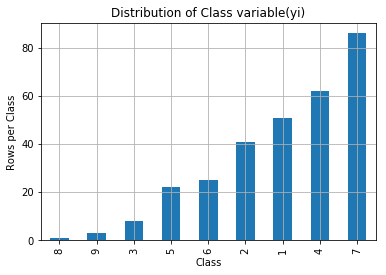

Number of rows belonging to class 9 : 86 ( 3.198 %)
Number of rows belonging to class 8 : 62 ( 2.306 %)
Number of rows belonging to class 7 : 51 ( 1.897 %)
Number of rows belonging to class 6 : 41 ( 1.525 %)
Number of rows belonging to class 5 : 25 ( 0.93 %)
Number of rows belonging to class 4 : 22 ( 0.818 %)
Number of rows belonging to class 3 : 8 ( 0.298 %)
Number of rows belonging to class 2 : 3 ( 0.112 %)
Number of rows belonging to class 1 : 1 ( 0.037 %)
----------------------------------------------------------------------


In [ ]:
check_distribution(train_class_distribution)
check_distribution(test_class_distribution)
check_distribution(cv_class_distribution)

# Random Model

We will take Log loss and Confusion matrix as our KPI.

For a Perfect Classifier the Log Loss is 0.

So for the log loss for a Random Classifier : 0 < Random Classifier < infinity 

Here Random Classifier will be our base line.

## What we will do is we will generate random values in between 0-9 and normalize to do be a sum of 1, becasue we are doing Random Model

In [ ]:
def confusionMatrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    
    labels = [1,2,3,4,5,6,7,8,9]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True,  fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True,  fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True,  fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

Log loss on Cross Validation Data using Random Model 2.4766781858145386
Log loss on Test Data using Random Model 2.453461992215976
-------------------- Confusion matrix --------------------


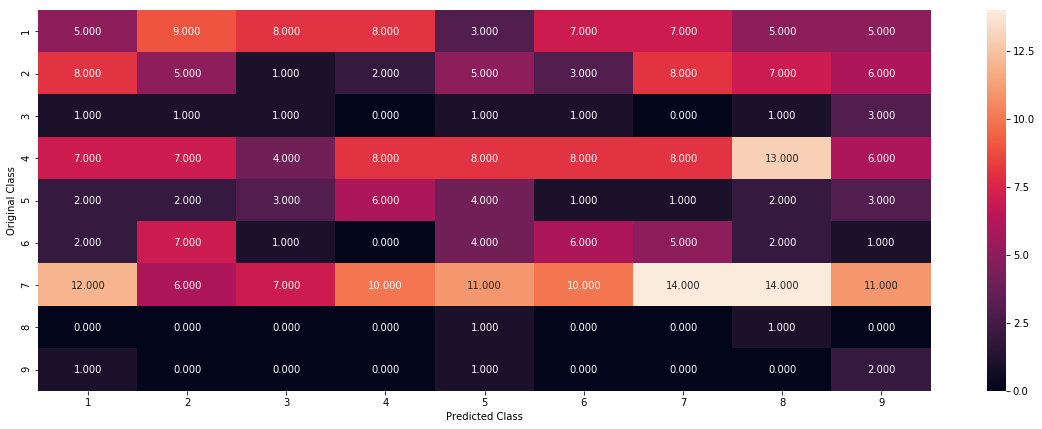

-------------------- Precision matrix (Columm Sum=1) --------------------


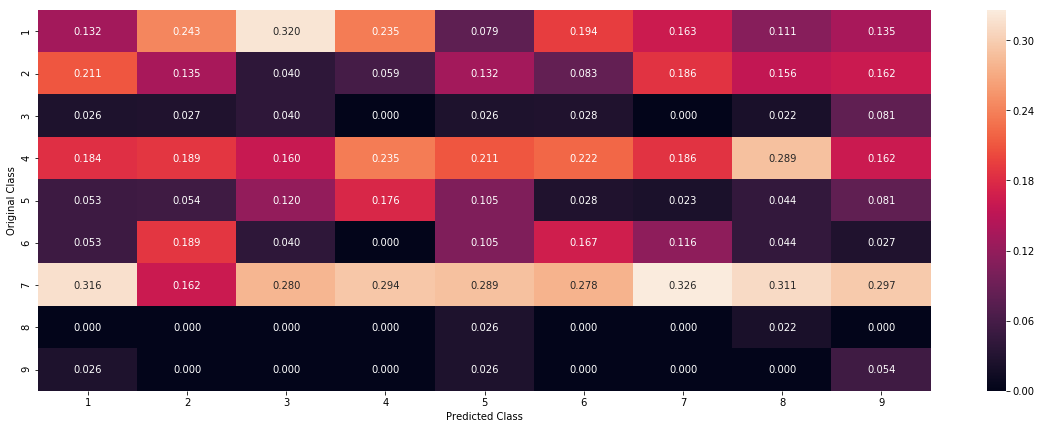

-------------------- Recall matrix (Row sum=1) --------------------


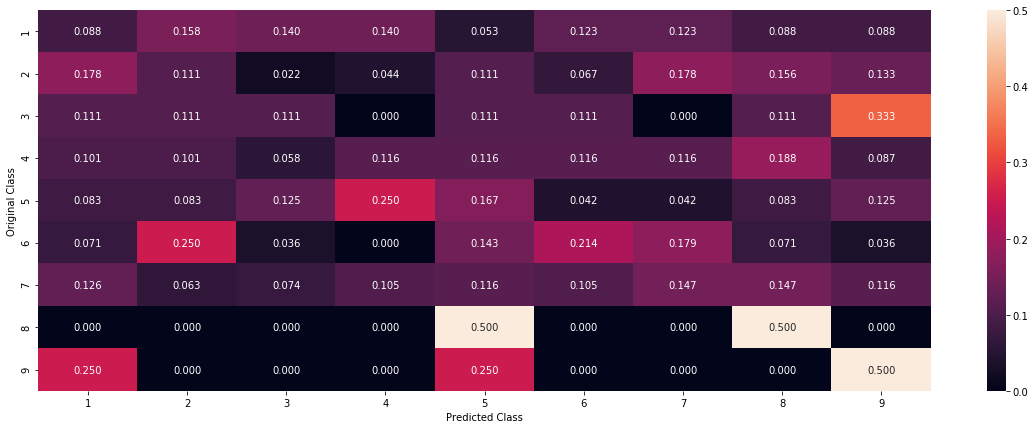

In [ ]:
test_data_len = test_df.shape[0]
cv_data_len = cv_df.shape[0]

cv_predicted_y = np.zeros((cv_data_len,9))

for i in range(cv_data_len):
    #Create an array of 1 row and 9 columns (0,1)
    rand_probs = np.random.rand(1,9)
    #
    cv_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Cross Validation Data using Random Model",log_loss(y_cv,cv_predicted_y, eps=1e-15))


test_predicted_y = np.zeros((test_data_len,9))
for i in range(test_data_len):
    rand_probs = np.random.rand(1,9)
    test_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test,test_predicted_y, eps=1e-15))

predict_y =np.argmax(test_predicted_y, axis=1)
confusionMatrix(y_test, predict_y+1)

In [ ]:
type(cv_predicted_y)

numpy.ndarray

In [ ]:
sum(sum(np.random.rand(1,9)))

4.6100993976464135

# Univariate Analysis

We take each feature and see if this feature is useful to predict the target variable.

Laplace smoothing is way to avoid overfitting

we will answer below question 

### Q1. Gene What type of Feature is this ?(categorical)
### Q2. How many categories are there and how are they distributed ?
### Q3. How to featurize the gene ?(Response encoding and One Hot Encoding)
### Q4. How good is this gene feature ?(we did a Logistic model with calibrated model because we need probability gene as IV for Class DV and checked the log loss with the random model)
### Q5. Is the Gene is is stable or not ? (It is stable beacsue the log loss of train and CV are almost same)

Number of Unique Genes : 250
BRCA1     220
TP53      137
EGFR      114
BRCA2     106
PTEN       99
KIT        83
BRAF       78
ALK        56
ERBB2      50
PDGFRA     47
Name: Gene, dtype: int64
250 different categories of genes in the train data, and they are distibuted as follows
****************************************************************************************************


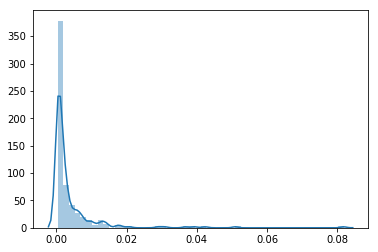

In [ ]:
unique_genes = train_df['Gene'].value_counts()
print('Number of Unique Genes :', unique_genes.shape[0])
# the top 10 genes that occured most
print(unique_genes.head(10))
print(unique_genes.shape[0] ,"different categories of genes in the train data, and they are distibuted as follows")
print('*'*100)

s = sum(unique_genes.values);
h = unique_genes.values/s;
#We can see the data is skewed 
sns.distplot(h, hist = True)

In [ ]:
def get_gv_fea_dict(alpha, feature, df):
    print(train_df['Variation'].value_counts())
    value_count = train_df[feature].value_counts()
    gv_dict = dict()
    for i, denominator in value_count.items():
        vec = []
        for k in range(1,10):
            cls_cnt = train_df.loc[(train_df['Class']==k) & (train_df[feature]==i)]
            vec.append((cls_cnt.shape[0] + alpha*10)/ (denominator + 90*alpha))
        gv_dict[i]=vec
    return gv_dict

# Get Gene variation feature
def get_gv_feature(alpha, feature, df):
    print(gv_dict)
    gv_dict = get_gv_fea_dict(alpha, feature, df)
    value_count = train_df[feature].value_counts()
    gv_fea = []
    for index, row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
            #gv_fea.append([-1,-1,-1,-1,-1,-1,-1,-1,-1])
    return gv_fea

We can see Top 50 genes has almost 75% of the data 


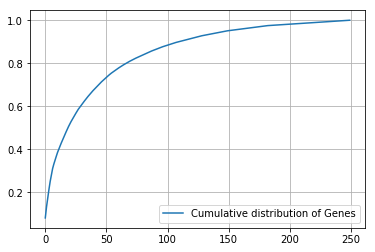

In [ ]:
#getting the cumulative sum
c = np.cumsum(h)
plt.plot(c,label='Cumulative distribution of Genes')
plt.grid()
plt.legend()
print("We can see Top 50 genes has almost 75% of the data ")

#    Response coding is nothing but Mean Value replacement
    
 We will choose the appropriate featurization based on the ML model we use.  For this problem of multi-class classification with categorical features, one-hot encoding is better for Logistic regression while response coding is better for Random Forests.
 
 when we caculate the probability of a feature belongs to any particular class, we apply laplace smoothing
(numerator + 10\*alpha) / (denominator + 90\*alpha) 

90 becasue we have 9 different classes 

In [ ]:
def get_gv_fea_dict(alpha, feature, df):
    # print(train_df['Gene'].value_counts())
    value_count = train_df[feature].value_counts()    
    # gv_dict : Gene Variation Dict, which contains the probability array for each gene/variation
    gv_dict = dict()
    for i, denominator in value_count.items():
        vec = []
        for k in range(1,10):
            # print(train_df.loc[(train_df['Class']==1) & (train_df['Gene']=='BRCA1')])
            # cls_cnt.shape[0] will return the number of rows
            cls_cnt = train_df.loc[(train_df['Class']==k) & (train_df[feature]==i)]            
            # cls_cnt.shape[0](numerator) will contain the number of time that particular feature occured in whole data
            vec.append((cls_cnt.shape[0] + alpha*10)/ (denominator + 90*alpha))
        gv_dict[i]=vec
    return gv_dict
def get_gv_feature(alpha, feature, df):
    # print(gv_dict)
    gv_dict = get_gv_fea_dict(alpha, feature, df)
    value_count = train_df[feature].value_counts()
    gv_fea = []
    for index, row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
    return gv_fea

In [ ]:
#response-coding of the Gene feature
# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", train_df))
# test gene feature
test_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", test_df))
# cross validation gene feature
cv_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", cv_df))

In [ ]:
print("train_gene_feature_responseCoding is converted feature using respone coding method. The shape of gene feature:", train_gene_feature_responseCoding.shape)

train_gene_feature_responseCoding is converted feature using respone coding method. The shape of gene feature: (2689, 9)


In [ ]:
# one-hot encoding of Gene feature.
gene_vectorizer = CountVectorizer()
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(train_df['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(test_df['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(cv_df['Gene'])

In [ ]:
train_df['Gene'].head()

2052       MYC
2673     BRCA1
2930    NFE2L2
187       EGFR
2761      BRAF
Name: Gene, dtype: object

In [ ]:
gene_vectorizer.get_feature_names()

['abl1',
 'acvr1',
 'ago2',
 'akt1',
 'akt2',
 'akt3',
 'alk',
 'apc',
 'ar',
 'araf',
 'arid1a',
 'arid1b',
 'arid2',
 'arid5b',
 'asxl1',
 'asxl2',
 'atm',
 'atr',
 'atrx',
 'aurka',
 'aurkb',
 'axin1',
 'axl',
 'b2m',
 'bap1',
 'bcl10',
 'bcl2l11',
 'bcor',
 'braf',
 'brca1',
 'brca2',
 'brd4',
 'brip1',
 'btk',
 'card11',
 'carm1',
 'casp8',
 'cbl',
 'ccnd1',
 'ccnd2',
 'ccnd3',
 'ccne1',
 'cdh1',
 'cdk12',
 'cdk4',
 'cdk6',
 'cdk8',
 'cdkn1a',
 'cdkn1b',
 'cdkn2a',
 'cdkn2b',
 'cdkn2c',
 'cebpa',
 'chek2',
 'cic',
 'crebbp',
 'ctcf',
 'ctnnb1',
 'ddr2',
 'dicer1',
 'dnmt3a',
 'dnmt3b',
 'dusp4',
 'egfr',
 'eif1ax',
 'elf3',
 'ep300',
 'epas1',
 'epcam',
 'erbb2',
 'erbb3',
 'erbb4',
 'ercc2',
 'ercc3',
 'ercc4',
 'erg',
 'errfi1',
 'esr1',
 'etv1',
 'etv6',
 'ewsr1',
 'ezh2',
 'fanca',
 'fat1',
 'fbxw7',
 'fgf19',
 'fgf3',
 'fgf4',
 'fgfr1',
 'fgfr2',
 'fgfr3',
 'fgfr4',
 'flt1',
 'flt3',
 'foxa1',
 'foxl2',
 'foxp1',
 'fubp1',
 'gata3',
 'gli1',
 'gna11',
 'gnaq',
 'gnas',
 'h3f3

We are using SGD classifier is a general puprpose classifier because by using this we can do a Logistic Regression and Linear-SVM(Linear-SVM has a hinge loss)

Logistics Regression has log-loss and l2-regularization,and in the l2-regularization there is a lamda(hyperparameter) value.


### The best way to check the feature importance is make model with one feature as independent variable and check the logloss for the same, and if the log loss is less than that of the log loss of the Random Model, then the feature is important.

### We will be taking the gene feature and use Logistice Regression with one hot encoded feature.

When alpha =  1e-05 The log loss is: 1.2470664799441493
When alpha =  0.0001 The log loss is: 1.2257764013562296
When alpha =  0.001 The log loss is: 1.2670205103925405
When alpha =  0.01 The log loss is: 1.390169753176533
When alpha =  0.1 The log loss is: 1.4775454733302997
When alpha =  1 The log loss is: 1.5213383188920693


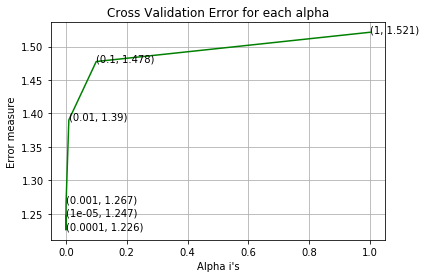

When alpha =  0.0001 The train log loss is: 0.9828027431484853
When alpha =  0.0001 The cross validation log loss is: 1.2257764013562296
When alpha =  0.0001 The test log loss is: 1.1757619176911653
********************************************************************************
We can see the the Log loss for train,Cross validation are almost same, so we are not overftting the model


In [ ]:
alpha = [10 ** x for x in range(-5, 1)] # hyperparam for SGD classifier.

cv_log_error_array=[]
for i in alpha:
    #when loss is log its a logistic regression, with l2 penalty and the alpha is lambda(hyperparameter)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_gene_feature_onehotCoding, y_train)
    #CalibratedClassifier is important when we use log loss as metric
    #CalibratedClassifier helps us to genrate probabilities of the target varibale with sigmoid 
    #So when the metric is Log Loss we should run all the output from our model through a CalibratedClassifier
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_gene_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('When alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_gene_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_gene_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_gene_feature_onehotCoding)
print('When alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
print('When alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_gene_feature_onehotCoding)
print('When alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

print('*'*80)

print("We can see the the Log loss for train,Cross validation are almost same, so we are not overftting the model")


In [ ]:
#Checking Whether the gene feture is Stable across all the dataset

print("data points in Test and CV datasets are covered by the ", unique_genes.shape[0], " genes in train dataset")

test_coverage=test_df[test_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]
cv_coverage=cv_df[cv_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]

print('In cross validation data', 'out of ',cv_df.shape[0],":","we have", cv_coverage ,"genes",(cv_coverage/cv_df.shape[0])*100, "% which are in the train data")
print('In cross validation data', 'out of ',test_df.shape[0],":","we have", cv_coverage ,"genes",(test_coverage/test_df.shape[0])*100, "% which are in the train data")

data points in Test and CV datasets are covered by the  250  genes in train dataset
In cross validation data out of  299 : we have 289 genes 96.65551839464884 % which are in the train data
In cross validation data out of  333 : we have 289 genes 98.49849849849849 % which are in the train data


Number of Unique Variation : 2435
Truncating_Mutations         79
Deletion                     58
Amplification                54
Fusions                      25
Overexpression                5
G12V                          4
E17K                          3
Q61R                          3
Q61L                          3
Promoter_Hypermethylation     2
Name: Variation, dtype: int64
2435 different categories of genes in the train data, and they are distibuted as follows
****************************************************************************************************


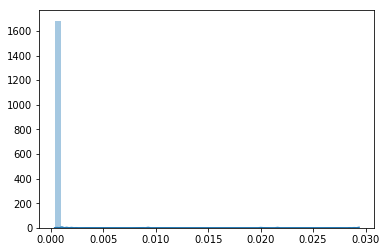

In [ ]:
unique_Variation = train_df['Variation'].value_counts()
print('Number of Unique Variation :', unique_Variation.shape[0])
# the top 10 genes that occured most
print(unique_Variation.head(10))
print(unique_Variation.shape[0] ,"different categories of genes in the train data, and they are distibuted as follows")
print('*'*100)

s = sum(unique_Variation.values);
h = unique_Variation.values/s;
#We can see the data is skewed 
sns.distplot(h, hist = True)

We can see Top 1500 variations has almost 80% of the data 


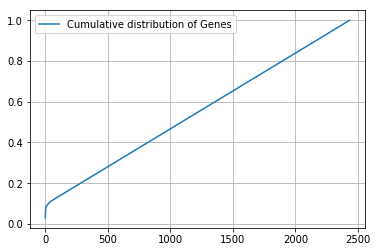

In [ ]:
c = np.cumsum(h)
plt.plot(c,label='Cumulative distribution of Genes')
plt.grid()
plt.legend()
#most of the variations occur once or twice 
print("We can see Top 1500 variations has almost 80% of the data ")

In [ ]:
# alpha is used for laplace smoothing
#If the feature is not present in the train dataset then we need to take it as equiprobable in the while using Response enccoding
alpha = 1
# train gene feature
train_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", train_df))
# test gene feature
test_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", test_df))
# cross validation gene feature
cv_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", cv_df))

In [ ]:
print("train_variation_feature_responseCoding is a converted feature using the response coding method. The shape of Variation feature:", train_variation_feature_responseCoding.shape)

train_variation_feature_responseCoding is a converted feature using the response coding method. The shape of Variation feature: (2689, 9)


In [ ]:
# one-hot encoding of variation feature.
variation_vectorizer = CountVectorizer()
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(train_df['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(test_df['Variation'])
cv_variation_feature_onehotCoding = variation_vectorizer.transform(cv_df['Variation'])

In [ ]:
print("train_variation_feature_onehotEncoded is converted feature using the onne-hot encoding method. The shape of Variation feature:", train_variation_feature_onehotCoding.shape)

train_variation_feature_onehotEncoded is converted feature using the onne-hot encoding method. The shape of Variation feature: (2689, 2464)


When alpha =  1e-05 The log loss is: 1.6826468716538439
When alpha =  0.0001 The log loss is: 1.672012794353265
When alpha =  0.001 The log loss is: 1.6674926283137965
When alpha =  0.01 The log loss is: 1.6724212076981027
When alpha =  0.1 The log loss is: 1.6893269856858861
When alpha =  1 The log loss is: 1.690752599738918


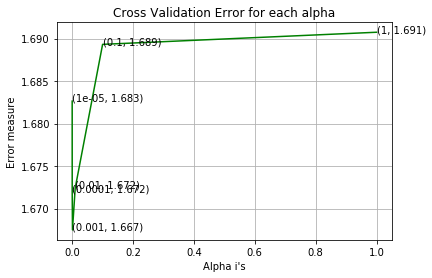

When alpha =  0.001 The train log loss is: 1.1583774181599056
When alpha =  0.001 The cross validation log loss is: 1.6674926283137965
When alpha =  0.001 The test log loss is: 1.7300260835220944


In [ ]:
alpha = [10 ** x for x in range(-5, 1)]

cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_variation_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_variation_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
    
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('When alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_variation_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_variation_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_variation_feature_onehotCoding)
print('When alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
print('When alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_variation_feature_onehotCoding)
print('When alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))



In [ ]:
#Checking Whether the gene feture is Stable across all the dataset
# The variation is instable because most of the variation occurs once or twice there is a more chance of instability in Train CV and Test

print( unique_Variation.shape[0], " variation in train dataset")

test_coverage=test_df[test_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]
cv_coverage=cv_df[cv_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]

print('In cross validation data', 'out of ',cv_df.shape[0],":","we have", cv_coverage ,"genes",(cv_coverage/cv_df.shape[0])*100, "% which are in the train data")
print('In cross validation data', 'out of ',test_df.shape[0],":","we have", test_coverage ,"genes",(test_coverage/test_df.shape[0])*100, "% which are in the train data")

print('*'*110)

print('Though the Variation feature is unstable but it has CV log loss and Train Log loss fairly small than the random model so we can consider it as important feature')

2435  variation in train dataset
In cross validation data out of  299 : we have 38 genes 12.709030100334449 % which are in the train data
In cross validation data out of  333 : we have 31 genes 9.30930930930931 % which are in the train data
**************************************************************************************************************
Though the Variation feature is unstable but it has CV log loss and Train Log loss fairly small than the random model so we can consider it as important feature


# Univariate Analysis for Text Feature
1. How many unique words are present in train data?
2. How are word frequencies distributed?
3. How to featurize text field?
4. Is the text feature useful in predicitng y_i?
5. Is the text feature stable across train, test and CV datasets?

In [ ]:
def extract_dictionary_paddle(cls_text):
    #initilization of dictionary
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows():
        #splitting the word by space
        for word in row['TEXT'].split():
            dictionary[word] +=1
    return dictionary

# One Hot EnCoding for text is simple Bag OF words
# Response Encoding for test is simple " Its the probability of the target value and the word ouucrs divided by the specici word occurs
# with some laplace smoothing"
Reference : https://stackoverflow.com/a/1602964

In [ ]:
import math
def get_text_responsecoding(df):
    text_feature_responseCoding = np.zeros((df.shape[0],9))
    for i in range(0,9):
        row_index = 0
        for index, row in df.iterrows():
            sum_prob = 0
            for word in row['TEXT'].split():
                sum_prob += math.log(((dict_list[i].get(word,0)+10 )/(total_dict.get(word,0)+90)))
            text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(row['TEXT'].split()))
            row_index += 1
    return text_feature_responseCoding

In [ ]:
# building a CountVectorizer with all the words that occured minimum 3 times in train data
text_vectorizer = CountVectorizer(min_df=3)
train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df['TEXT'])

# getting all the feature names (words)
train_text_features= text_vectorizer.get_feature_names()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))

# We haev already removed the stop words
print("Total number of unique words(not stop words) in train data :", len(train_text_features))

Total number of unique words(not stop words) in train data : 59757


In [ ]:
dict_list = []
# dict_list =[] contains 9 dictoinaries each corresponds to a class
for i in range(1,10):
    cls_text = train_df[train_df['Class']==i]
    # build a word dict based on the words in that class
    dict_list.append(extract_dictionary_paddle(cls_text))
    # append it to dict_list

# dict_list[i] is build on i'th  class text data
# total_dict is buid on whole training text data
total_dict = extract_dictionary_paddle(train_df)


confuse_array = []
for i in train_text_features:
    ratios = []
    max_val = -1
    for j in range(0,9):
        ratios.append((dict_list[j][i]+10 )/(total_dict[i]+90))
    confuse_array.append(ratios)
confuse_array = np.array(confuse_array)

In [ ]:
#response coding of text features
train_text_feature_responseCoding  = get_text_responsecoding(train_df)
test_text_feature_responseCoding  = get_text_responsecoding(test_df)
cv_text_feature_responseCoding  = get_text_responsecoding(cv_df)

In [ ]:
# we convert each row values such that they sum to 1 beacsue the sum of the 9 probabilities should be 1 
train_text_feature_responseCoding = (train_text_feature_responseCoding.T/train_text_feature_responseCoding.sum(axis=1)).T
test_text_feature_responseCoding = (test_text_feature_responseCoding.T/test_text_feature_responseCoding.sum(axis=1)).T
cv_text_feature_responseCoding = (cv_text_feature_responseCoding.T/cv_text_feature_responseCoding.sum(axis=1)).T

In [ ]:
#Nromalizing the features

train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
test_text_feature_onehotCoding = text_vectorizer.transform(test_df['TEXT'])
# don't forget to normalize every feature
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature_onehotCoding = text_vectorizer.transform(cv_df['TEXT'])
# don't forget to normalize every feature
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

In [ ]:
#https://stackoverflow.com/questions/613183/how-do-i-sort-a-dictionary-by-value/2258273#2258273
sorted_text_fea_dict = dict(sorted(text_fea_dict.items(), key=lambda x: x[1] , reverse=True))
sorted_text_occur = np.array(list(sorted_text_fea_dict.values()))

In [ ]:
# This will show how many times
print(Counter(sorted_text_occur))

Counter({3: 5611, 4: 4550, 5: 2967, 6: 2922, 7: 2274, 8: 2154, 9: 1862, 10: 1792, 12: 1647, 11: 1608, 14: 961, 15: 916, 13: 847, 16: 839, 20: 809, 18: 729, 17: 719, 23: 600, 24: 599, 19: 585, 21: 557, 22: 548, 26: 470, 27: 414, 28: 404, 25: 395, 30: 382, 32: 369, 36: 311, 29: 310, 55: 308, 31: 291, 33: 290, 37: 280, 38: 270, 35: 262, 34: 261, 65: 247, 42: 245, 39: 240, 40: 239, 41: 215, 51: 203, 46: 200, 45: 199, 43: 189, 50: 181, 48: 177, 44: 171, 56: 164, 52: 156, 47: 156, 54: 155, 49: 153, 60: 145, 59: 137, 66: 136, 57: 136, 72: 134, 69: 130, 63: 123, 62: 123, 58: 121, 64: 120, 53: 119, 77: 115, 76: 112, 75: 110, 61: 108, 68: 107, 71: 105, 67: 102, 82: 99, 73: 99, 70: 99, 84: 93, 80: 92, 74: 92, 83: 86, 78: 86, 102: 85, 87: 84, 81: 82, 79: 82, 85: 81, 90: 79, 92: 78, 101: 76, 110: 74, 88: 72, 94: 71, 86: 71, 91: 69, 89: 68, 100: 67, 99: 65, 98: 64, 93: 64, 97: 62, 95: 61, 130: 60, 96: 60, 108: 58, 112: 56, 132: 55, 134: 54, 105: 54, 109: 52, 120: 51, 113: 51, 169: 50, 129: 50, 144: 

Whenf alpha =  1e-05 The log loss is: 1.2788444153295961
Whenf alpha =  0.0001 The log loss is: 1.2122498987364831
Whenf alpha =  0.001 The log loss is: 1.260196431748193
Whenf alpha =  0.01 The log loss is: 1.498345205020829
Whenf alpha =  0.1 The log loss is: 1.5517538079509332
Whenf alpha =  1 The log loss is: 1.69975858002815


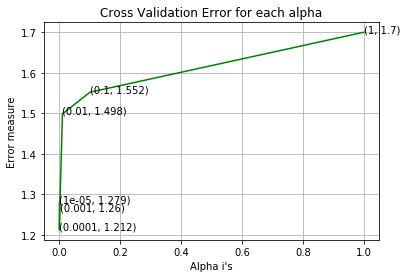

When alpha =  0.0001 The train log loss is: 0.6299172812110833
When alpha =  0.0001 The cross validation log loss is: 1.2122498987364831
When alpha =  0.0001 The test log loss is: 1.1993213954505695


In [ ]:
# Train a Logistic regression with Calibration model using text features whicha are on-hot encoded
alpha = [10 ** x for x in range(-5, 1)]

cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_text_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_text_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('Whenf alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_text_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_text_feature_onehotCoding)
print('When alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
print('When alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_text_feature_onehotCoding)
print('When alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


In [ ]:
def get_intersec_text(df):
    df_text_vec = CountVectorizer(min_df=3)
    df_text_fea = df_text_vec.fit_transform(df['TEXT'])
    df_text_features = df_text_vec.get_feature_names()

    df_text_fea_counts = df_text_fea.sum(axis=0).A1
    df_text_fea_dict = dict(zip(list(df_text_features),df_text_fea_counts))
    len1 = len(set(df_text_features))
    len2 = len(set(train_text_features) & set(df_text_features))
    return len1,len2

In [ ]:
len1,len2 = get_intersec_text(test_df)
print(np.round((len2/len1)*100, 3), "% of word of test data appeared in train data")
len1,len2 = get_intersec_text(cv_df)
print(np.round((len2/len1)*100, 3), "% of word of Cross Validation appeared in train data")

98.876 % of word of test data appeared in train data
99.799 % of word of Cross Validation appeared in train data


Summary of the Univariate Analysis of the features
![image.png](attachment:image.png)

# Machine Learning Models

## we will do the following models 

### 1. Logistic regression
### 2. Support Vector Machines
### 3. Naive Bayes

#### We are using all those above models beacuse after One Hot Encoding we have a high dimensional data, in simple words which means it has a lot of columns and tree based method will not able to handle high dimensional data properly, but models like Logistics regression, Linear SVM and Naive Bayes can handle those high dimensional data quite nicely

In [ ]:
def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we willl provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    confusionMatrix(test_y, pred_y)

In [ ]:
def report_log_loss(train_x, train_y, test_x, test_y,  clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps=1e-15)

In [ ]:
# this function will be used just for naive bayes
# for the given indices, we will print the name of the features
# and we will check whether the feature present in the test point text or not
def get_impfeature_names(indices, text, gene, var, no_features):
    gene_count_vec = CountVectorizer()
    var_count_vec = CountVectorizer()
    text_count_vec = CountVectorizer(min_df=3)
    
    gene_vec = gene_count_vec.fit(train_df['Gene'])
    var_vec  = var_count_vec.fit(train_df['Variation'])
    text_vec = text_count_vec.fit(train_df['TEXT'])
    
    fea1_len = len(gene_vec.get_feature_names())
    fea2_len = len(var_count_vec.get_feature_names())
    
    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = gene_vec.get_feature_names()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word,yes_no))
        elif (v < fea1_len+fea2_len):
            word = var_vec.get_feature_names()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:
            word = text_vec.get_feature_names()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))

    print("Out of the top ",no_features," features ", word_present, "are present in query point")

In [ ]:
# merging gene, variance and text features
#hstack will only concatnate the features
train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
train_y = np.array(list(train_df['Class']))

test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(test_df['Class']))

cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()
cv_y = np.array(list(cv_df['Class']))


train_gene_var_responseCoding = np.hstack((train_gene_feature_responseCoding,train_variation_feature_responseCoding))
test_gene_var_responseCoding = np.hstack((test_gene_feature_responseCoding,test_variation_feature_responseCoding))
cv_gene_var_responseCoding = np.hstack((cv_gene_feature_responseCoding,cv_variation_feature_responseCoding))

train_x_responseCoding = np.hstack((train_gene_var_responseCoding, train_text_feature_responseCoding))
test_x_responseCoding = np.hstack((test_gene_var_responseCoding, test_text_feature_responseCoding))
cv_x_responseCoding = np.hstack((cv_gene_var_responseCoding, cv_text_feature_responseCoding))

In [ ]:
print("One hot encoding features :")
print("(number of data points * number of features) in train data = ", train_x_onehotCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_onehotCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_onehotCoding.shape)

print('*'* 100)

print(" Response encoding features :")
print("(number of data points * number of features) in train data = ", train_x_responseCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_responseCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_responseCoding.shape)

One hot encoding features :
(number of data points * number of features) in train data =  (2689, 62470)
(number of data points * number of features) in test data =  (333, 62470)
(number of data points * number of features) in cross validation data = (299, 62470)
****************************************************************************************************
 Response encoding features :
(number of data points * number of features) in train data =  (2689, 27)
(number of data points * number of features) in test data =  (333, 27)
(number of data points * number of features) in cross validation data = (299, 27)


# 1. BaseLine Naive Bayes

for alpha = 1e-05
Log Loss : 1.2646374757711263
for alpha = 0.0001
Log Loss : 1.2540056182386774
for alpha = 0.001
Log Loss : 1.2353643782436492
for alpha = 0.1
Log Loss : 1.2314191805608772
for alpha = 1
Log Loss : 1.2339804747158933
for alpha = 10
Log Loss : 1.4225777380859537
for alpha = 100
Log Loss : 1.521429603673462
for alpha = 1000
Log Loss : 1.5165827060517023


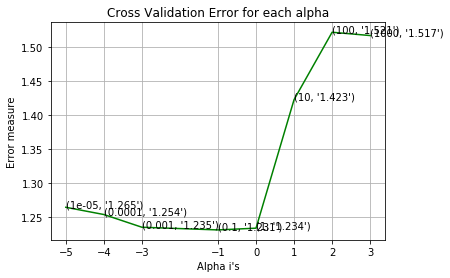

When alpha =  0.1 The train log loss is: 0.8555807887515354
When alpha =  0.1 The cross validation log loss is: 1.2314191805608772
When alpha =  0.1 The test log loss is: 1.2788628130136583


In [ ]:
alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)


predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('When alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('When alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('When alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


Log Loss : 1.2314191805608772
Number of missclassified point : 0.3712374581939799
-------------------- Confusion matrix --------------------


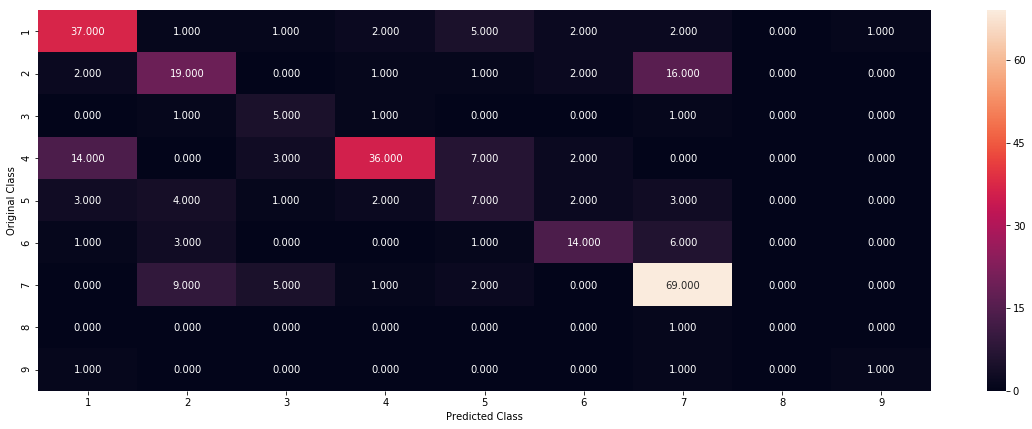

-------------------- Precision matrix (Columm Sum=1) --------------------


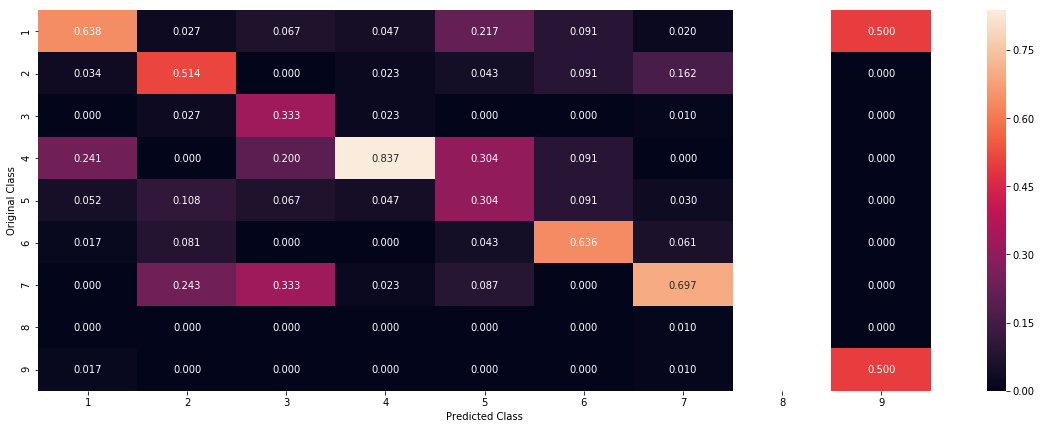

-------------------- Recall matrix (Row sum=1) --------------------


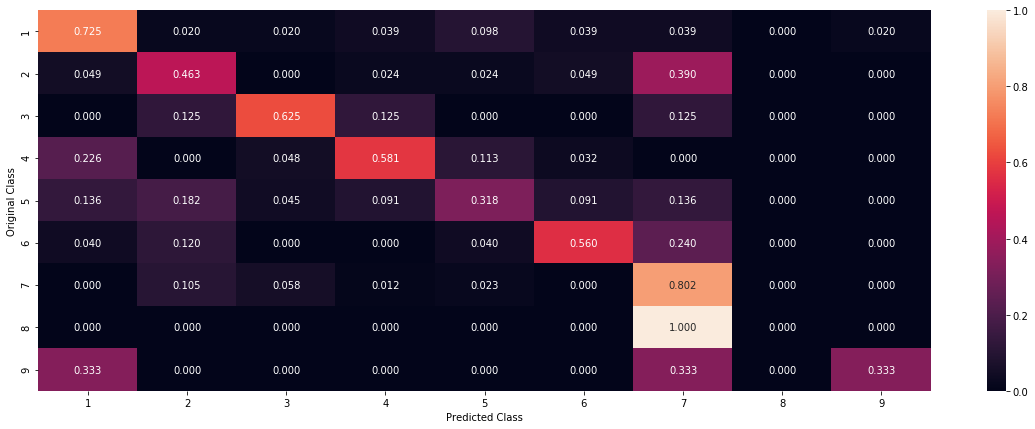

In [ ]:
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)
sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
# to avoid rounding error while multiplying probabilites we use log-probability estimates
print("Log Loss :",log_loss(cv_y, sig_clf_probs))
print("Number of missclassified point :", np.count_nonzero((sig_clf.predict(cv_x_onehotCoding)- cv_y))/cv_y.shape[0])
confusionMatrix(cv_y, sig_clf.predict(cv_x_onehotCoding.toarray()))

In [ ]:
cv_y.shape

(299,)

In [ ]:
x = sig_clf.predict(cv_x_onehotCoding.toarray())

In [ ]:
x.shape

(299,)

In [ ]:
test_point_index = 4
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices=np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
#print("-"*50)
#get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 2
Predicted Class Probabilities: [[0.0835 0.4653 0.0125 0.1113 0.0441 0.0416 0.2315 0.0063 0.0039]]
Actual Class : 2


# Logistic Regression with Class Balancing

for alpha = 1e-06
Log Loss : 1.3352135567750196
for alpha = 1e-05
Log Loss : 1.2211326073817372
for alpha = 0.0001
Log Loss : 1.1937167425485178
for alpha = 0.001
Log Loss : 1.1820592113475972
for alpha = 0.01
Log Loss : 1.274315328920179
for alpha = 0.1
Log Loss : 1.5190219843011585
for alpha = 1
Log Loss : 1.7744461294201024
for alpha = 10
Log Loss : 1.8028118275982992
for alpha = 100
Log Loss : 1.8056829968024


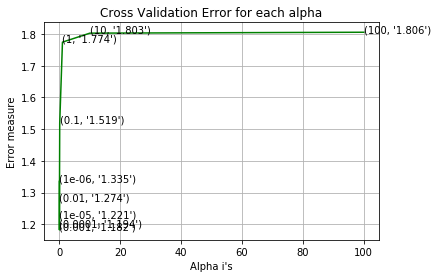

When alpha =  0.001 The train log loss is: 0.5066150448675132
When alpha =  0.001 The cross validation log loss is: 1.1820592113475972
When alpha =  0.001 The test log loss is: 1.2156057571033485


In [ ]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    #As long as the loss = log the SGDClassifier works as Logistic Regression
    # We are using balanced class weight with l2 regularizer
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('When alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('When alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('When alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

Log loss : 1.1820592113475972
Number of mis-classified points : 0.32441471571906355
-------------------- Confusion matrix --------------------


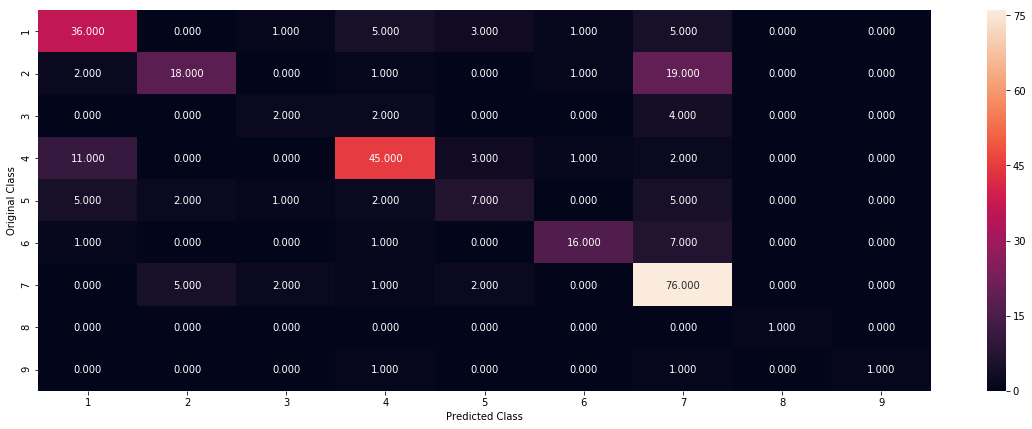

-------------------- Precision matrix (Columm Sum=1) --------------------


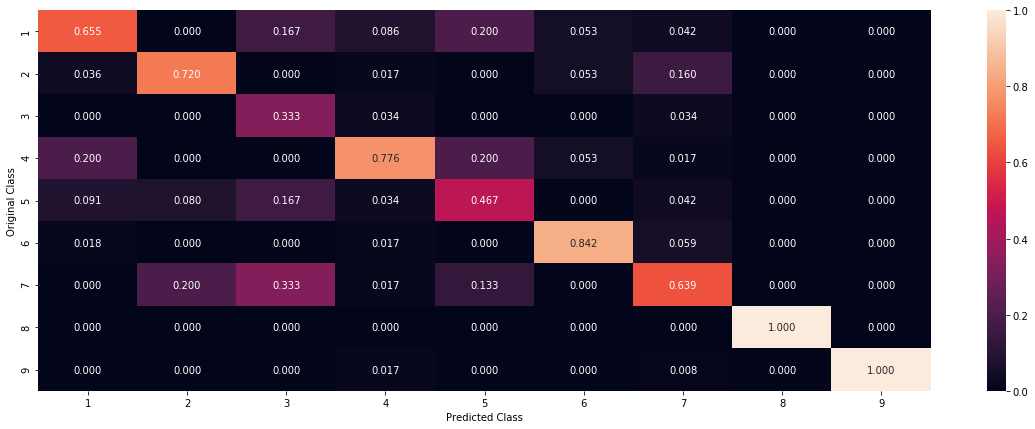

-------------------- Recall matrix (Row sum=1) --------------------


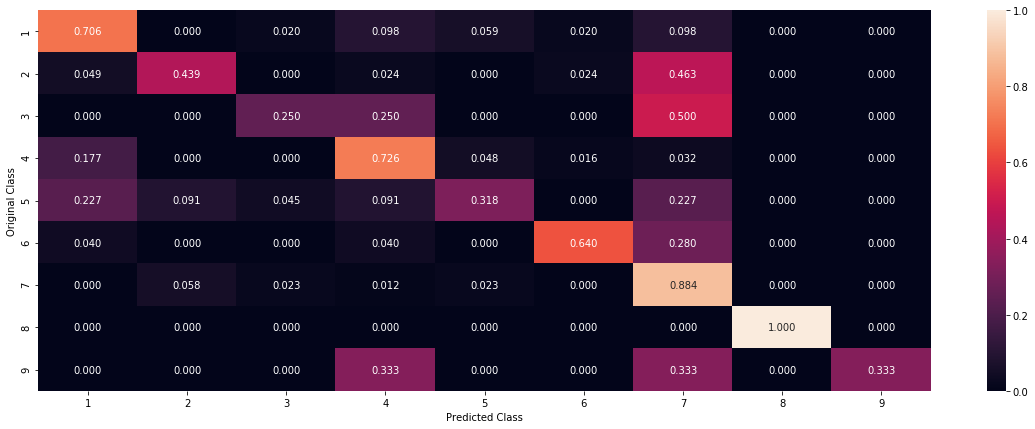

In [ ]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

In [ ]:
def get_imp_feature_names(text, indices, removed_ind = []):
    word_present = 0
    tabulte_list = []
    incresingorder_ind = 0
    for i in indices:
        if i < train_gene_feature_onehotCoding.shape[1]:
            tabulte_list.append([incresingorder_ind, "Gene", "Yes"])
        elif i< 18:
            tabulte_list.append([incresingorder_ind,"Variation", "Yes"])
        if ((i > 17) & (i not in removed_ind)) :
            word = train_text_features[i]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
            tabulte_list.append([incresingorder_ind,train_text_features[i], yes_no])
        incresingorder_ind += 1
    print(word_present, "most importent features are present in our query point")
    print("-"*50)
    print("The features that are most importent of the ",predicted_cls[0]," class:")
    print (tabulate(tabulte_list, headers=["Index",'Feature name', 'Present or Not']))

In [ ]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 100 #4
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 5
Predicted Class Probabilities: [[0.0934 0.0785 0.0152 0.1154 0.2774 0.2641 0.1473 0.0047 0.004 ]]
Actual Class : 6
--------------------------------------------------
23 Text feature [identified] present in test data point [True]
27 Text feature [revealed] present in test data point [True]
29 Text feature [two] present in test data point [True]
30 Text feature [shown] present in test data point [True]
32 Text feature [mutations] present in test data point [True]
33 Text feature [found] present in test data point [True]
34 Text feature [using] present in test data point [True]
36 Text feature [confirmed] present in test data point [True]
37 Text feature [similar] present in test data point [True]
38 Text feature [described] present in test data point [True]
42 Text feature [mutant] present in test data point [True]
44 Text feature [whether] present in test data point [True]
45 Text feature [may] present in test data point [True]
49 Text feature [total] present in test

267 Text feature [28] present in test data point [True]
273 Text feature [generate] present in test data point [True]
275 Text feature [per] present in test data point [True]
277 Text feature [caused] present in test data point [True]
280 Text feature [37] present in test data point [True]
281 Text feature [subsequent] present in test data point [True]
282 Text feature [resulted] present in test data point [True]
283 Text feature [others] present in test data point [True]
285 Text feature [affect] present in test data point [True]
287 Text feature [many] present in test data point [True]
288 Text feature [33] present in test data point [True]
290 Text feature [cases] present in test data point [True]
291 Text feature [changes] present in test data point [True]
292 Text feature [absence] present in test data point [True]
293 Text feature [alter] present in test data point [True]
294 Text feature [common] present in test data point [True]
296 Text feature [provide] present in test data p

In [ ]:
test_point_index = 4
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 5
Predicted Class Probabilities: [[0.0934 0.0785 0.0152 0.1154 0.2774 0.2641 0.1473 0.0047 0.004 ]]
Actual Class : 6
--------------------------------------------------
23 Text feature [identified] present in test data point [True]
27 Text feature [revealed] present in test data point [True]
29 Text feature [two] present in test data point [True]
30 Text feature [shown] present in test data point [True]
32 Text feature [mutations] present in test data point [True]
33 Text feature [found] present in test data point [True]
34 Text feature [using] present in test data point [True]
36 Text feature [confirmed] present in test data point [True]
37 Text feature [similar] present in test data point [True]
38 Text feature [described] present in test data point [True]
42 Text feature [mutant] present in test data point [True]
44 Text feature [whether] present in test data point [True]
45 Text feature [may] present in test data point [True]
49 Text feature [total] present in test

273 Text feature [generate] present in test data point [True]
275 Text feature [per] present in test data point [True]
277 Text feature [caused] present in test data point [True]
280 Text feature [37] present in test data point [True]
281 Text feature [subsequent] present in test data point [True]
282 Text feature [resulted] present in test data point [True]
283 Text feature [others] present in test data point [True]
285 Text feature [affect] present in test data point [True]
287 Text feature [many] present in test data point [True]
288 Text feature [33] present in test data point [True]
290 Text feature [cases] present in test data point [True]
291 Text feature [changes] present in test data point [True]
292 Text feature [absence] present in test data point [True]
293 Text feature [alter] present in test data point [True]
294 Text feature [common] present in test data point [True]
296 Text feature [provide] present in test data point [True]
297 Text feature [data] present in test data

# Logistic Regression without Class Balancing

for alpha = 1e-06
Log Loss : 1.3159652254584142
for alpha = 1e-05
Log Loss : 1.2443514553426553
for alpha = 0.0001
Log Loss : 1.2114421027491102
for alpha = 0.001
Log Loss : 1.201740230779319
for alpha = 0.01
Log Loss : 1.4165215195420613
for alpha = 0.1
Log Loss : 1.5133041100831301
for alpha = 1
Log Loss : 1.6550069964123044


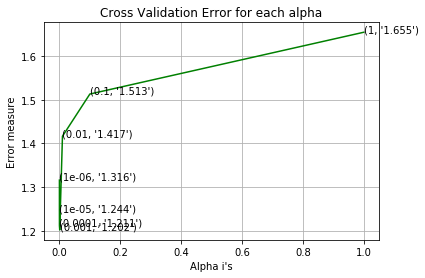

When alpha =  0.001 The train log loss is: 0.5064722402530815
When alpha =  0.001 The cross validation log loss is: 1.201740230779319
When alpha =  0.001 The test log loss is: 1.2178716273869512


In [ ]:
alpha = [10 ** x for x in range(-6, 1)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('When alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('When alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('When alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

Log loss : 1.201740230779319
Number of mis-classified points : 0.3311036789297659
-------------------- Confusion matrix --------------------


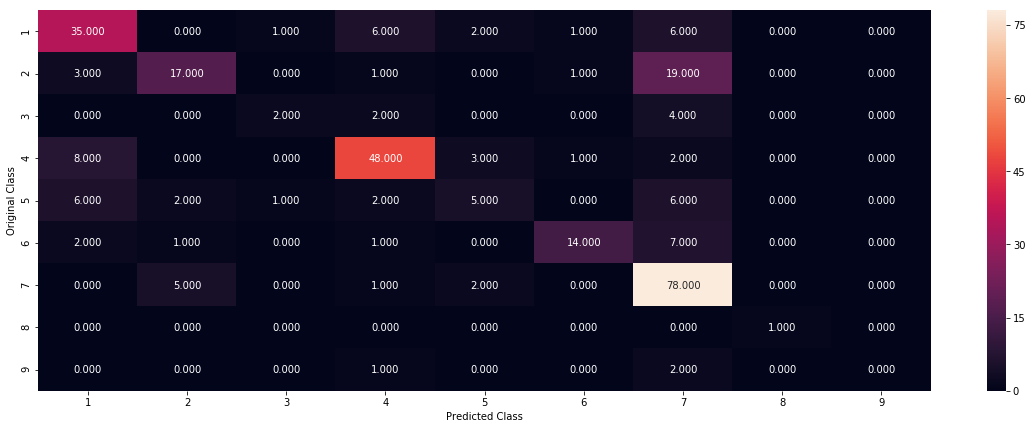

-------------------- Precision matrix (Columm Sum=1) --------------------


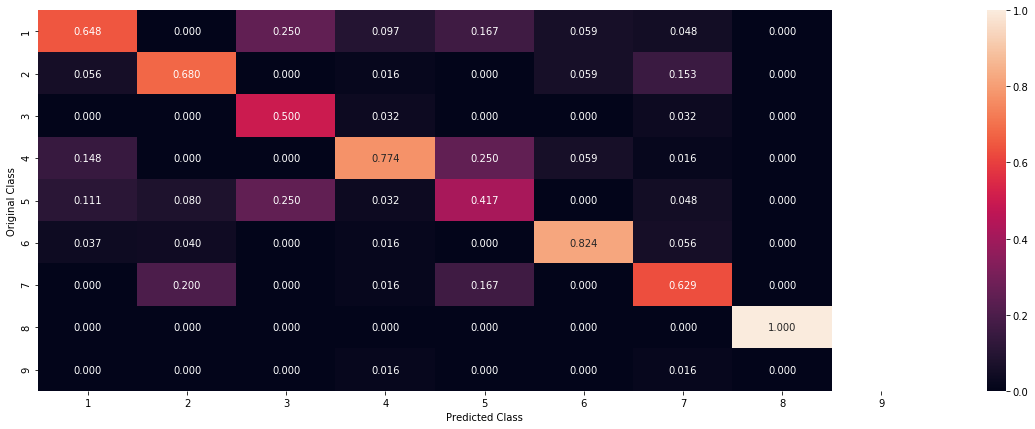

-------------------- Recall matrix (Row sum=1) --------------------


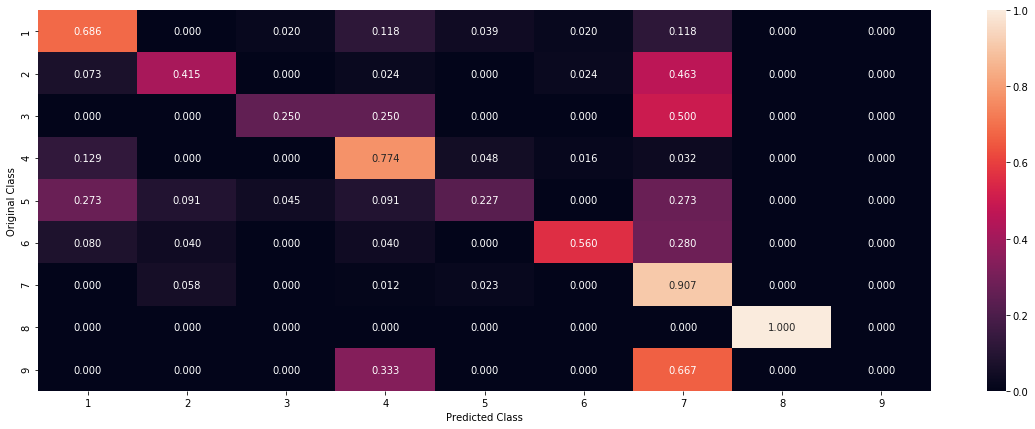

In [ ]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

In [ ]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 5
Predicted Class Probabilities: [[3.940e-02 7.400e-03 1.000e-04 2.000e-04 8.146e-01 0.000e+00 1.373e-01
  1.000e-03 0.000e+00]]
Actual Class : 7
--------------------------------------------------
352 Text feature [figure22] present in test data point [True]
449 Text feature [identified] present in test data point [True]
Out of the top  500  features  2 are present in query point


In [ ]:
test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.1701 0.1357 0.0282 0.2048 0.0735 0.083  0.2842 0.0077 0.0128]]
Actual Class : 2
--------------------------------------------------
1 Text feature [cancers] present in test data point [True]
3 Text feature [number] present in test data point [True]
6 Text feature [myc] present in test data point [True]
9 Text feature [cyclin] present in test data point [True]
11 Text feature [fgfr1] present in test data point [True]
13 Text feature [downstream] present in test data point [True]
17 Text feature [increased] present in test data point [True]
20 Text feature [used] present in test data point [True]
21 Text feature [secondary] present in test data point [True]
22 Text feature [activated] present in test data point [True]
24 Text feature [amplification] present in test data point [True]
26 Text feature [nick] present in test data point [True]
29 Text feature [11] present in test data point [True]
31 Text feature [copy] present in test dat

315 Text feature [actin] present in test data point [True]
316 Text feature [resulted] present in test data point [True]
318 Text feature [mb] present in test data point [True]
322 Text feature [alone] present in test data point [True]
325 Text feature [ligand] present in test data point [True]
334 Text feature [progression] present in test data point [True]
335 Text feature [case] present in test data point [True]
336 Text feature [see] present in test data point [True]
338 Text feature [technology] present in test data point [True]
340 Text feature [frequent] present in test data point [True]
341 Text feature [gfp] present in test data point [True]
343 Text feature [36] present in test data point [True]
347 Text feature [binding] present in test data point [True]
348 Text feature [metastasis] present in test data point [True]
350 Text feature [age] present in test data point [True]
351 Text feature [pathway] present in test data point [True]
352 Text feature [functions] present in te

# Linear Support Vector Machine

for C = 1e-05
Log Loss : 1.232295777541451
for C = 0.0001
Log Loss : 1.214320967453472
for C = 0.001
Log Loss : 1.1516565817917925
for C = 0.01
Log Loss : 1.1106378687743936
for C = 0.1
Log Loss : 1.4300343263997282
for C = 1
Log Loss : 1.7912971309882124
for C = 10
Log Loss : 1.8060820584149082
for C = 100
Log Loss : 1.8060809697793259


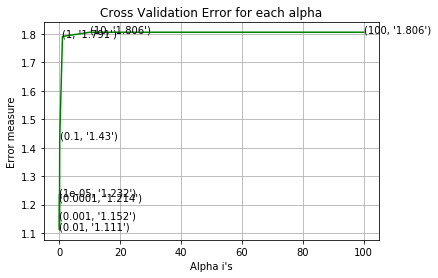

When alpha =  0.01 The train log loss is: 0.7559368476774122
When alpha =  0.01 The cross validation log loss is: 1.1106378687743936
When alpha =  0.01 The test log loss is: 1.1934489504992882


In [ ]:
alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
#     clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
    clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
# clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('When alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('When alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('When alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

Log loss : 1.822331598624613
Number of mis-classified points : 0.7123745819397993
-------------------- Confusion matrix --------------------


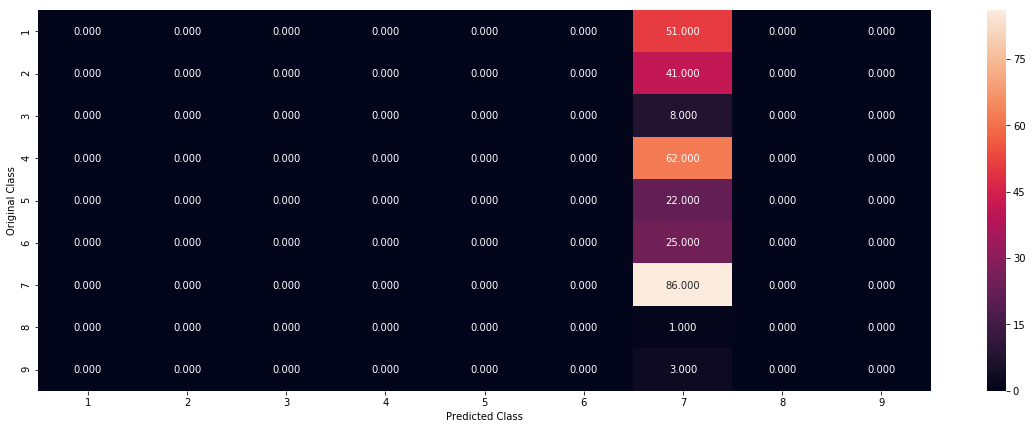

-------------------- Precision matrix (Columm Sum=1) --------------------


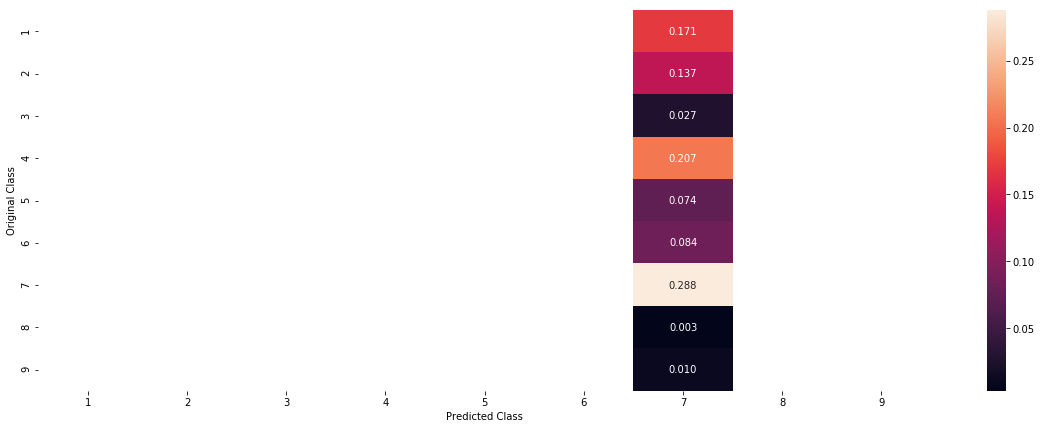

-------------------- Recall matrix (Row sum=1) --------------------


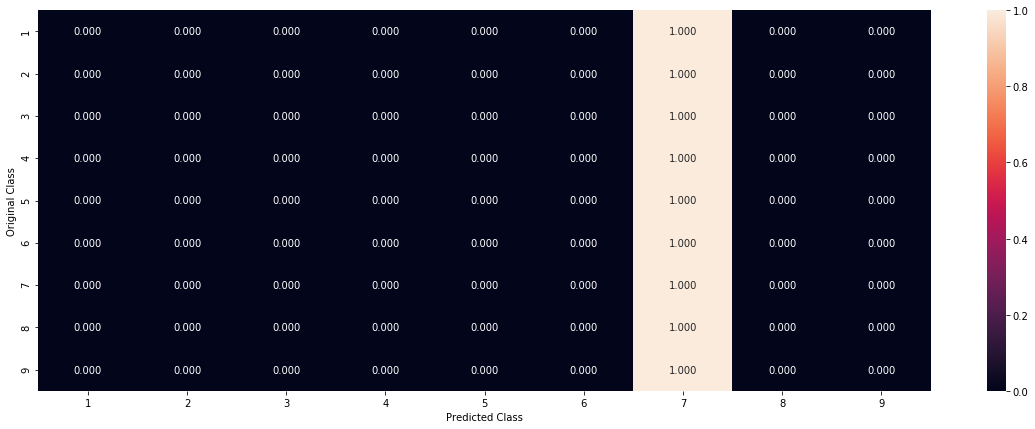

In [ ]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42,class_weight='balanced')
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

In [ ]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
# test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 5
Predicted Class Probabilities: [[0.0203 0.0124 0.0042 0.0166 0.9324 0.0048 0.0062 0.002  0.001 ]]
Actual Class : 7
--------------------------------------------------
422 Text feature [figure22] present in test data point [True]
Out of the top  500  features  1 are present in query point


In [ ]:
test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 3
Predicted Class Probabilities: [[0.0112 0.0203 0.8107 0.0181 0.0141 0.0088 0.1133 0.0024 0.0012]]
Actual Class : 3
--------------------------------------------------
392 Text feature [2c] present in test data point [True]
402 Text feature [2a] present in test data point [True]
437 Text feature [identified] present in test data point [True]
454 Text feature [mutation] present in test data point [True]
458 Text feature [1d] present in test data point [True]
460 Text feature [2d] present in test data point [True]
466 Text feature [novel] present in test data point [True]
468 Text feature [keywords] present in test data point [True]
476 Text feature [2b] present in test data point [True]
487 Text feature [somatic] present in test data point [True]
Out of the top  500  features  10 are present in query point


# Random Forest With One Hot Encoded Feature

In [ ]:
alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_onehotCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_onehotCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('When estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('When estimator = ', alpha[int(best_alpha/2)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('When estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for n_estimators = 100 and max depth =  5
Log Loss : 1.3186578082194769
for n_estimators = 100 and max depth =  10
Log Loss : 1.2136956648201345
for n_estimators = 200 and max depth =  5
Log Loss : 1.3133252099113555
for n_estimators = 200 and max depth =  10
Log Loss : 1.201842648890086
for n_estimators = 500 and max depth =  5
Log Loss : 1.3031795710401584
for n_estimators = 500 and max depth =  10
Log Loss : 1.2042396199062093
for n_estimators = 1000 and max depth =  5
Log Loss : 1.306160746158967
for n_estimators = 1000 and max depth =  10
Log Loss : 1.207058813931289
for n_estimators = 2000 and max depth =  5
Log Loss : 1.3073494828089125
for n_estimators = 2000 and max depth =  10
Log Loss : 1.2050415926748057
When estimator =  200 The train log loss is: 0.7225388202066388
When estimator =  200 The cross validation log loss is: 1.201842648890086
When estimator =  200 The test log loss is: 1.189697602131754


Log loss : 1.201842648890086
Number of mis-classified points : 0.3779264214046823
-------------------- Confusion matrix --------------------


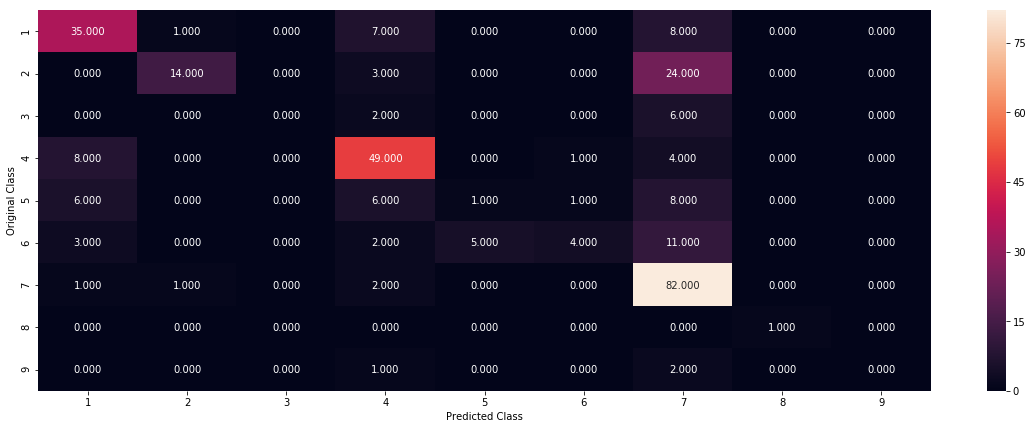

-------------------- Precision matrix (Columm Sum=1) --------------------


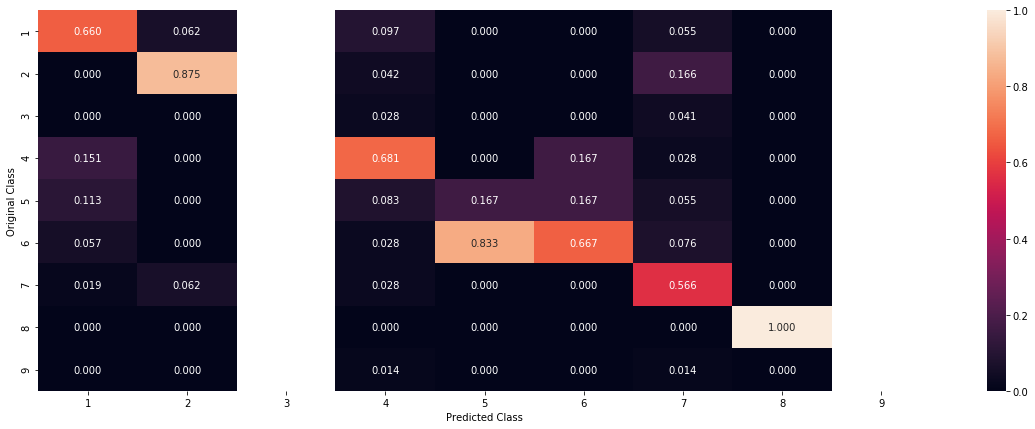

-------------------- Recall matrix (Row sum=1) --------------------


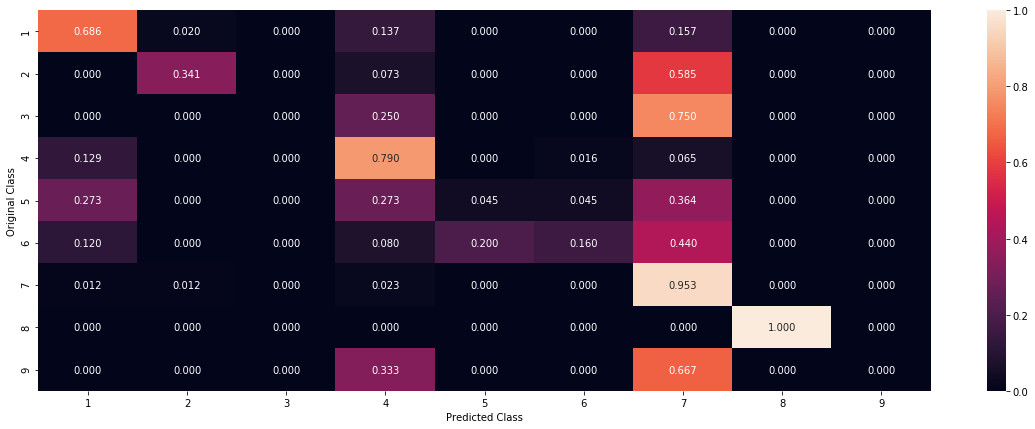

In [ ]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

In [ ]:
# test_point_index = 10
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
get_impfeature_names(indices[:no_feature], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.1162 0.1303 0.0254 0.1051 0.1734 0.0514 0.3796 0.0095 0.0091]]
Actual Class : 7
--------------------------------------------------
0 Text feature [activating] present in test data point [True]
1 Text feature [tyrosine] present in test data point [True]
2 Text feature [inhibitors] present in test data point [True]
3 Text feature [kinase] present in test data point [True]
4 Text feature [inhibitor] present in test data point [True]
5 Text feature [signaling] present in test data point [True]
6 Text feature [activation] present in test data point [True]
7 Text feature [treatment] present in test data point [True]
8 Text feature [phosphorylation] present in test data point [True]
9 Text feature [stability] present in test data point [True]
11 Text feature [downstream] present in test data point [True]
12 Text feature [function] present in test data point [True]
13 Text feature [drug] present in test data point [True]
20 Text feature [k

In [ ]:
test_point_index = 100
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actuall Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
get_impfeature_names(indices[:no_feature], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0501 0.1219 0.0369 0.0604 0.0408 0.0312 0.6451 0.0065 0.0071]]
Actuall Class : 3
--------------------------------------------------
0 Text feature [activating] present in test data point [True]
2 Text feature [inhibitors] present in test data point [True]
3 Text feature [kinase] present in test data point [True]
4 Text feature [inhibitor] present in test data point [True]
5 Text feature [signaling] present in test data point [True]
6 Text feature [activation] present in test data point [True]
7 Text feature [treatment] present in test data point [True]
8 Text feature [phosphorylation] present in test data point [True]
12 Text feature [function] present in test data point [True]
14 Text feature [months] present in test data point [True]
19 Text feature [null] present in test data point [True]
21 Text feature [missense] present in test data point [True]
22 Text feature [activated] present in test data point [True]
23 Text feature [pt

# Random Forest With Response Encoding

In [ ]:
alpha = [10,50,100,200,500,1000]
max_depth = [2,3,5,10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_responseCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_responseCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 
best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('When alpha = ', alpha[int(best_alpha/4)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('When alpha = ', alpha[int(best_alpha/4)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('When alpha = ', alpha[int(best_alpha/4)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for n_estimators = 10 and max depth =  2
Log Loss : 2.1557315726718222
for n_estimators = 10 and max depth =  3
Log Loss : 1.6916409604883327
for n_estimators = 10 and max depth =  5
Log Loss : 1.6243593723427898
for n_estimators = 10 and max depth =  10
Log Loss : 1.8147618466253177
for n_estimators = 50 and max depth =  2
Log Loss : 1.9087139606237404
for n_estimators = 50 and max depth =  3
Log Loss : 1.5725388605107065
for n_estimators = 50 and max depth =  5
Log Loss : 1.4248353440211101
for n_estimators = 50 and max depth =  10
Log Loss : 1.672920924629283
for n_estimators = 100 and max depth =  2
Log Loss : 1.742767877391334
for n_estimators = 100 and max depth =  3
Log Loss : 1.607053717260255
for n_estimators = 100 and max depth =  5
Log Loss : 1.3812618796968306
for n_estimators = 100 and max depth =  10
Log Loss : 1.694063297166183
for n_estimators = 200 and max depth =  2
Log Loss : 1.7689662764093987
for n_estimators = 200 and max depth =  3
Log Loss : 1.6618636762194696
f

Log loss : 1.4599760430208129
Number of mis-classified points : 0.5484949832775919
-------------------- Confusion matrix --------------------


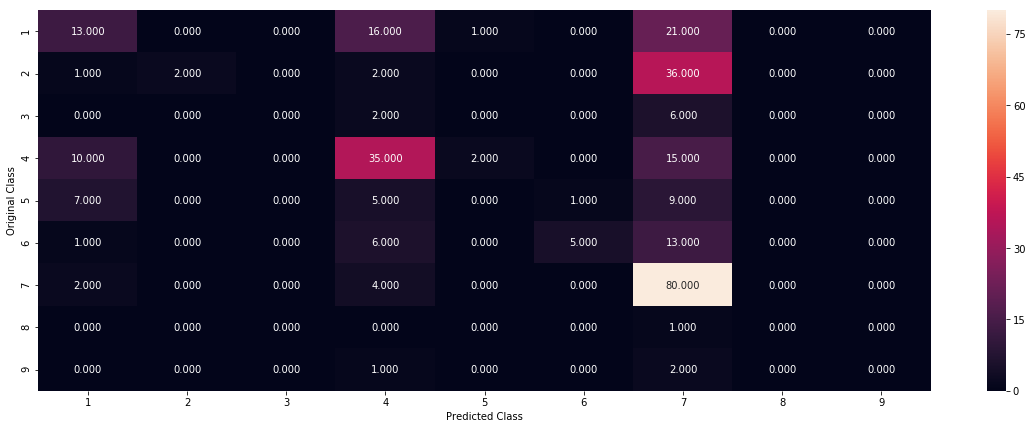

-------------------- Precision matrix (Columm Sum=1) --------------------


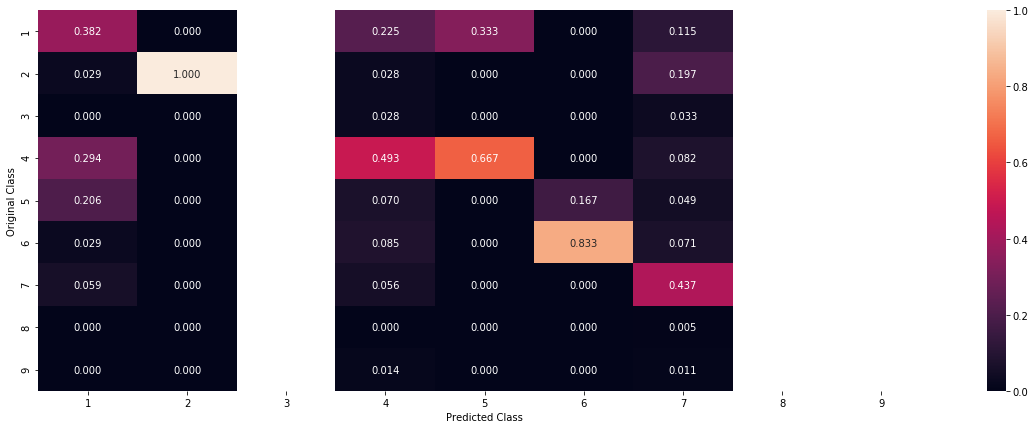

-------------------- Recall matrix (Row sum=1) --------------------


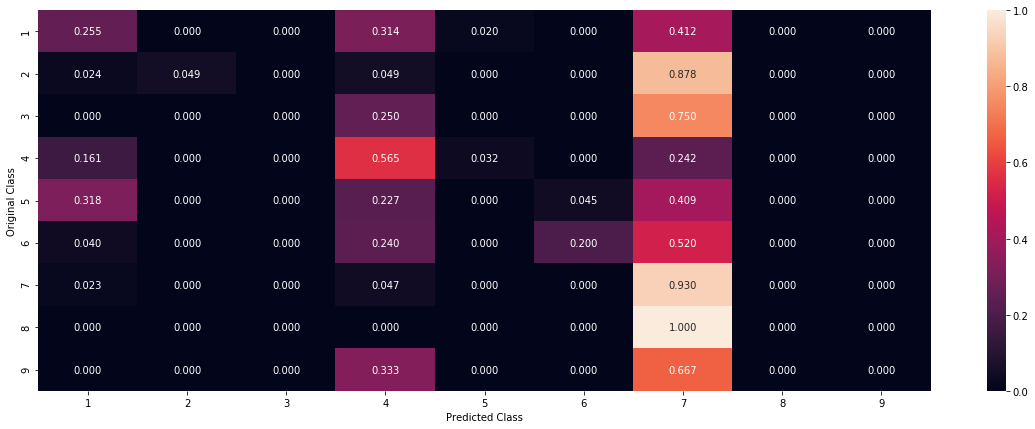

In [ ]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

In [ ]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)


test_point_index = 1
no_feature = 27
predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_responseCoding[test_point_index].reshape(1,-1)),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
for i in indices:
    if i<9:
        print("Gene is important feature")
    elif i<18:
        print("Variation is important feature")
    else:
        print("Text is important feature")

Predicted Class : 7
Predicted Class Probabilities: [[0.0162 0.2457 0.1399 0.0306 0.1122 0.0673 0.3309 0.0399 0.0175]]
Actual Class : 7
--------------------------------------------------
Variation is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Gene is important feature
Variation is important feature
Variation is important feature
Text is important feature
Text is important feature
Gene is important feature
Text is important feature
Text is important feature
Text is important feature
Gene is important feature
Variation is important feature
Gene is important feature
Gene is important feature
Text is important feature
Gene is important feature
Variation is important feature
Variation is important feature
Text is important feature
Text is important feature
Gene is important feature
Gene is important feature
Text is important feature
Gene is important feature


In [ ]:
test_point_index = 100
predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_responseCoding[test_point_index].reshape(1,-1)),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
for i in indices:
    if i<9:
        print("Gene is important feature")
    elif i<18:
        print("Variation is important feature")
    else:
        print("Text is important feature")

Predicted Class : 3
Predicted Class Probabilities: [[0.0073 0.0951 0.649  0.0127 0.0217 0.0266 0.1609 0.0176 0.009 ]]
Actual Class : 3
--------------------------------------------------
Variation is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Gene is important feature
Variation is important feature
Variation is important feature
Text is important feature
Text is important feature
Gene is important feature
Text is important feature
Text is important feature
Text is important feature
Gene is important feature
Variation is important feature
Gene is important feature
Gene is important feature
Text is important feature
Gene is important feature
Variation is important feature
Variation is important feature
Text is important feature
Text is important feature
Gene is important feature
Gene is important feature
Text is important feature
Gene is important feature


# Stacking The Model

The problem with stacking model is its interpretability

In [ ]:
clf1 = SGDClassifier(alpha=0.001, penalty='l2', loss='log', class_weight='balanced', random_state=0)
clf1.fit(train_x_onehotCoding, train_y)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

clf2 = SGDClassifier(alpha=0.01, penalty='l2', loss='hinge', class_weight='balanced', random_state=0)
clf2.fit(train_x_onehotCoding, train_y)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")


clf3 = MultinomialNB(alpha=0.1)
clf3.fit(train_x_onehotCoding, train_y)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

sig_clf1.fit(train_x_onehotCoding, train_y)
print("Logistic Regression :  Log Loss: %0.2f" % (log_loss(cv_y, sig_clf1.predict_proba(cv_x_onehotCoding))))
sig_clf2.fit(train_x_onehotCoding, train_y)
print("Support vector machines : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf2.predict_proba(cv_x_onehotCoding))))
sig_clf3.fit(train_x_onehotCoding, train_y)
print("Naive Bayes : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf3.predict_proba(cv_x_onehotCoding))))
print("-"*50)
alpha = [0.0001,0.001,0.01,0.1,1,10] 
best_alpha = 999
for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
    sclf.fit(train_x_onehotCoding, train_y)
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" % (i, log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))))
    log_error =log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
    if best_alpha > log_error:
        best_alpha = log_error

Logistic Regression :  Log Loss: 1.18
Support vector machines : Log Loss: 1.11
Naive Bayes : Log Loss: 1.23
--------------------------------------------------
Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 1.796
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 1.618
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 1.167
Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 1.172
Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 1.457
Stacking Classifer : for the value of alpha: 10.000000 Log Loss: 1.836


Log loss (train) on the stacking classifier : 1.6053791058101943
Log loss (CV) on the stacking classifier : 1.6177478764689448
Log loss (test) on the stacking classifier : 1.6429091763912458
Number of missclassified point : 0.5465465465465466
-------------------- Confusion matrix --------------------


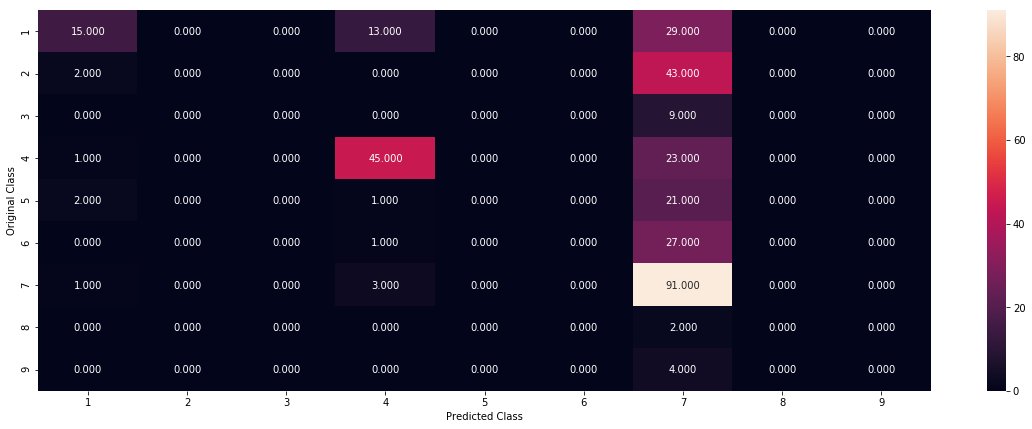

-------------------- Precision matrix (Columm Sum=1) --------------------


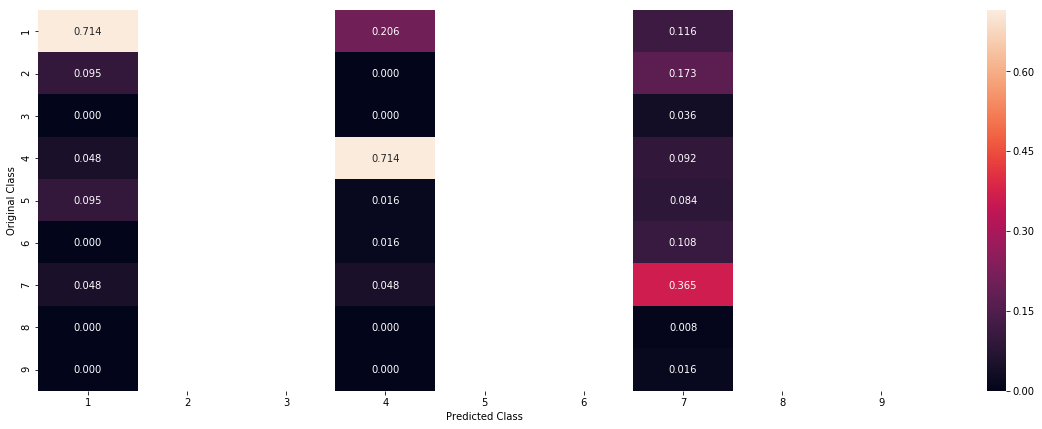

-------------------- Recall matrix (Row sum=1) --------------------


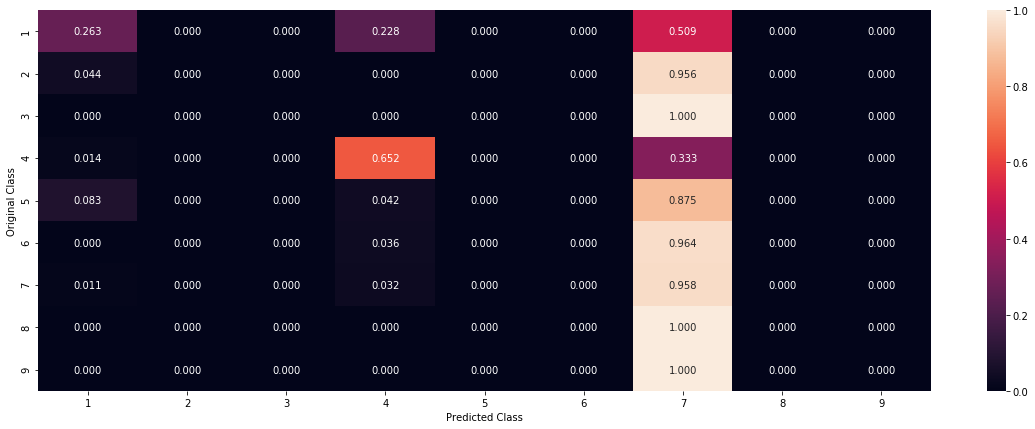

In [ ]:
lr = LogisticRegression(C=0.001)
sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
sclf.fit(train_x_onehotCoding, train_y)

log_error = log_loss(train_y, sclf.predict_proba(train_x_onehotCoding))
print("Log loss (train) on the stacking classifier :",log_error)

log_error = log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
print("Log loss (CV) on the stacking classifier :",log_error)

log_error = log_loss(test_y, sclf.predict_proba(test_x_onehotCoding))
print("Log loss (test) on the stacking classifier :",log_error)

print("Number of missclassified point :", np.count_nonzero((sclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
confusionMatrix(test_y=test_y, predict_y=sclf.predict(test_x_onehotCoding))

Log loss (train) on the VotingClassifier : 0.6693769353953367
Log loss (CV) on the VotingClassifier : 1.0353147791346549
Log loss (test) on the VotingClassifier : 1.0941337637746875
Number of missclassified point : 0.36036036036036034
-------------------- Confusion matrix --------------------


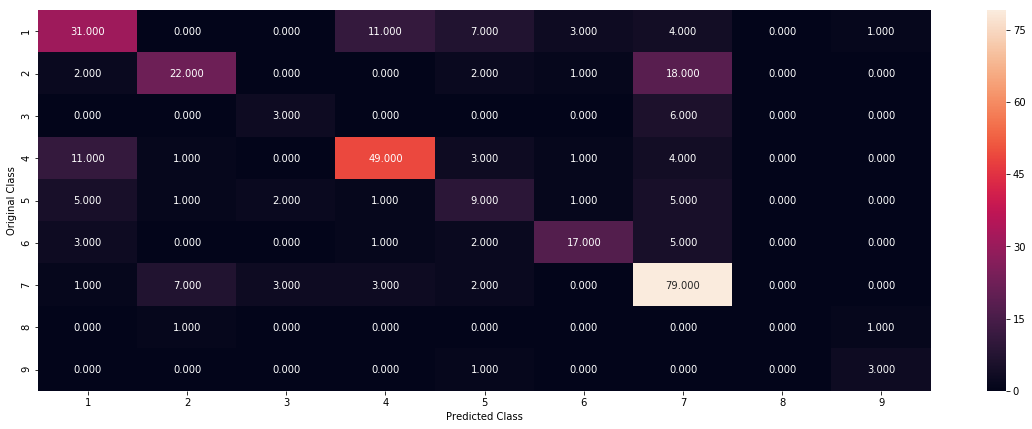

-------------------- Precision matrix (Columm Sum=1) --------------------


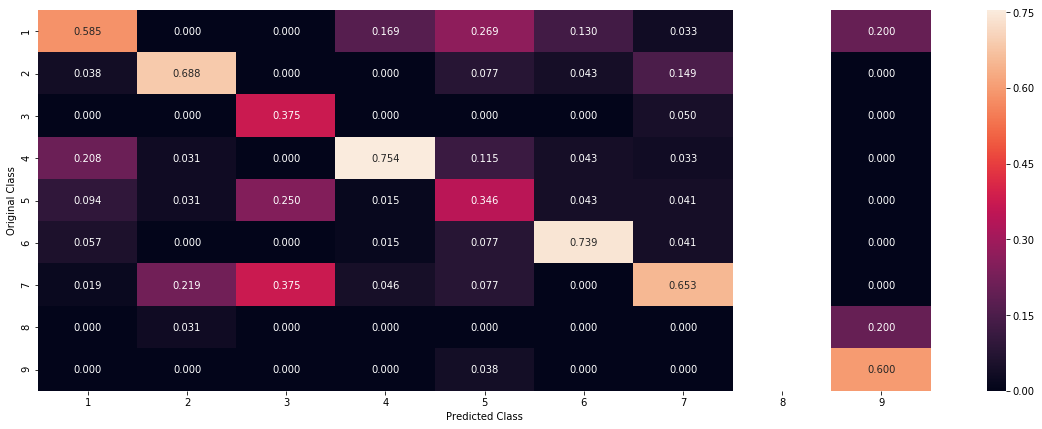

-------------------- Recall matrix (Row sum=1) --------------------


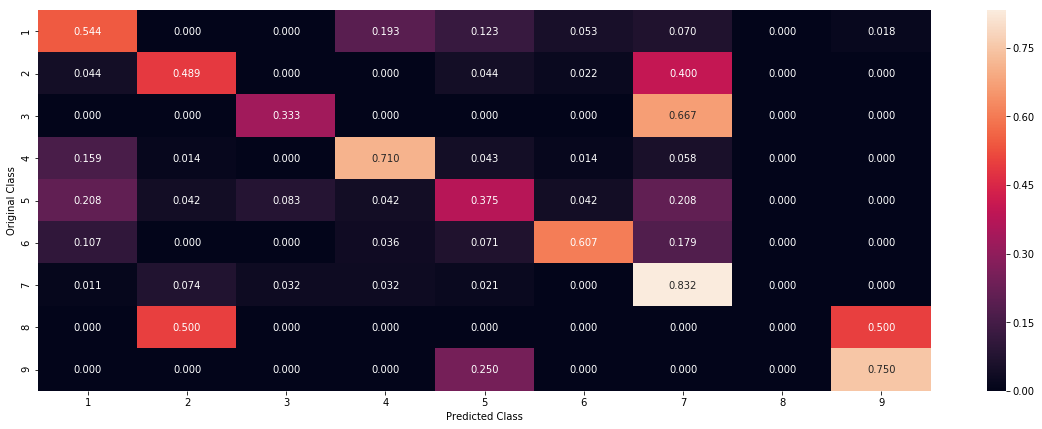

In [ ]:
from sklearn.ensemble import VotingClassifier
#Voting soft means we only take the probabilities.
vclf = VotingClassifier(estimators=[('lr', sig_clf1), ('svc', sig_clf2), ('rf', sig_clf3)], voting='soft')
vclf.fit(train_x_onehotCoding, train_y)
print("Log loss (train) on the VotingClassifier :", log_loss(train_y, vclf.predict_proba(train_x_onehotCoding)))
print("Log loss (CV) on the VotingClassifier :", log_loss(cv_y, vclf.predict_proba(cv_x_onehotCoding)))
print("Log loss (test) on the VotingClassifier :", log_loss(test_y, vclf.predict_proba(test_x_onehotCoding)))
print("Number of missclassified point :", np.count_nonzero((vclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
confusionMatrix(test_y=test_y, predict_y=vclf.predict(test_x_onehotCoding))